# Saqeeb's Pokedex


Welcome to my own personal Pokedex, where I'll be using a residual neural network to build a classifier that can identify any of the original 151 pokemon!


First, we need to grab the data. Luckily there is already a nice dataset on kaggle.com.
It is, however, missing two pokemon: the male and female nidorans. I'm planning to gather the data for this later. Right now we'll be training with 149 classes.


In [1]:
import scipy
import cv2
import opendatasets as od

# dataset_url = 'https://www.kaggle.com/thedagger/pokemon-generation-one' # You will need a kaggle token for this
# od.download(dataset_url)

In [2]:
import os

DATA_DIR = './pokemon-generation-one/dataset'
classes = os.listdir(DATA_DIR)
print(classes)

['Abra', 'Aerodactyl', 'Alakazam', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Nidoqueen', 'Nidorina'

To normalize the images, we first have to calculate the mean and standard deviation of the dataset. This takes a while and is bottlenecked by my HDD, so we'll try to read it from a file, and if the file doesn't exist, we'll calculate it manually and save it to a file for next time.

In [3]:
import json
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt


def mean_std(batch):
    '''Calculate the means and standard deviations of all images in a batch by colour channel'''
    images, labels = next(iter(batch))
    # shape of images = [b,c,w,h]
    mean, std = images.mean([0,2,3]), images.std([0,2,3])
    return mean, std

try:
    with open('stats.data', 'r') as filehandle: # open file for reading
        stats = json.load(filehandle)
    print("Loaded mean and standard deviation from file.")
    print(stats)
    mean, std = stats
    write = False
except:
    print("stats.data does not exist in the root directory. Calculating the mean and standard deviation:")
    write = True

if write:
    # Create a temporary dataset to get the mean and std

    image_size = 128

    stats_tfms = tt.Compose([tt.Resize(image_size),
                            tt.CenterCrop(image_size),
                            tt.ToTensor()])

    stats_set = ImageFolder(DATA_DIR, stats_tfms)
    dl = DataLoader(stats_set, batch_size=len(stats_set))

    mean, std = mean_std(dl)
    stats = mean.tolist(), std.tolist()
    print(stats)

    with open('stats.data', 'w') as filehandle: # open file for writing
        json.dump((stats), filehandle)
    print("Stats saved in stats.data.")

Loaded mean and standard deviation from file.
[[0.6265952587127686, 0.6168700456619263, 0.5776289105415344], [0.34548431634902954, 0.32877394556999207, 0.34652984142303467]]


Now we need to standardize the dataset in terms of image size. Due to memory constraints, each image should be no more than 128x128 pixels. Below, I create two instances of the dataset. That's because I don't have the files separated into training and validations sets, so instead I applied two random_split()s with the same seed. This allows for the training and validation sets to have different transformations/augmentations applied to them.

In [4]:
image_size = 128
batch_size = 64
stats = mean, std

train_tfms = tt.Compose([tt.Resize(image_size),
                         # tt.Resize(image_size, max_size=image_size),
                         # tt.Pad(padding=[(128 - image[0])/2 if image[0]<128 else 0, (128 - image[1])/2 if image[1]<128 else 0]),
                         tt.CenterCrop(image_size),
                         tt.RandomCrop(image_size, padding=8, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), 
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])

valid_tfms = tt.Compose([tt.Resize(image_size),
                         tt.CenterCrop(image_size),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])

dataset  = ImageFolder(DATA_DIR, train_tfms)
dataset2 = ImageFolder(DATA_DIR, valid_tfms)


Now we split the dataset into training and validation sets, with a seed for consistency and reproducibility.

In [5]:
from torch.utils.data import random_split

random_seed = 42
torch.manual_seed(random_seed);

valid_percent = 0.2
valid_size = int(valid_percent * len(dataset))
train_size = len(dataset) - valid_size

train_ds,  valid_ds  = random_split(dataset,  [train_size, valid_size]) # has the train_tfms transforms

torch.manual_seed(random_seed);
train_ds2, valid_ds2 = random_split(dataset2, [train_size, valid_size]) # has the valid_tfms transforms

del train_ds2
del valid_ds

len(train_ds), len(valid_ds2), len(dataset) # Sanity check

(8524, 2130, 10654)

Now let's set up some data loaders. I'll start with a batch size of 64, and increase it if it's training too slowly and I have extra GPU memory.

In [39]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds2, batch_size*2, num_workers=4, pin_memory=True)

Let's take a look at some of the images to make sure nothing went wrong so far.

In [7]:
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means
    # return (images-means)/stds

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

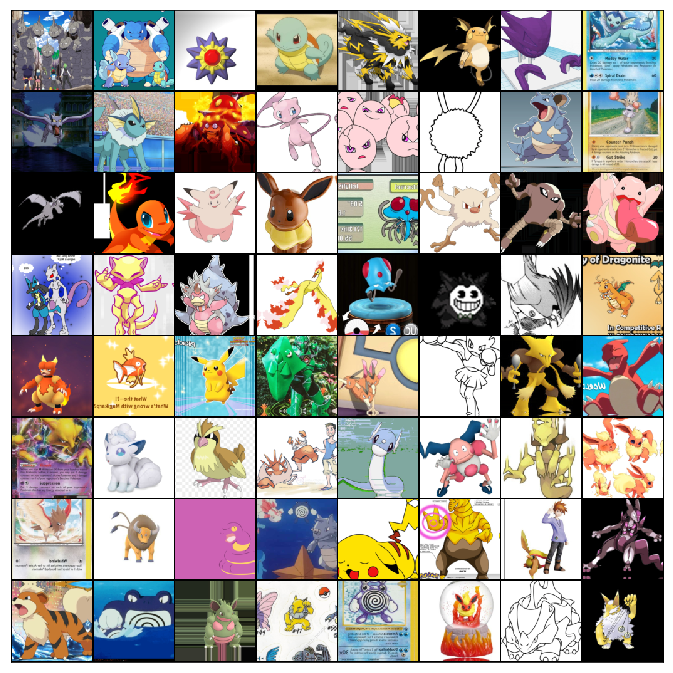

In [8]:
show_batch(train_dl)

In [9]:
for images, labels in train_dl: # Sanity check
    print(images.shape)
    break

torch.Size([64, 3, 128, 128])


## Loading data onto the GPU

Alright, we've got all our data formatted and ready to go! Let's load everything onto the GPU.

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We created a wrapper `DeviceDataLoader` to wrap around our dataloaders and transfer them to the GPU. I think this code came from fast.ai.

In [43]:
device = get_default_device()
print(device)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

cuda


## Creating the model

We'll start with a 9 layer ResNet as described [here](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/). The layers are shown in this image:

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

First, let's define a base classification class that has useful methods for reporting the performance of the model.

In [41]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassification(nn.Module):
    # The constructor will go in the child class
    def training_loss(self, batch):
        images, labels = batch
        predictions = self(images)                  # get predictions
        loss = F.cross_entropy(predictions, labels) # calculate loss
        return loss

    def validation_loss(self, batch):
        images, labels = batch
        predictions = self(images)                  # get predictions
        loss = F.cross_entropy(predictions, labels) # calculate loss
        acc = accuracy(predictions, labels)         # calculate accuracy
        return {"val_loss": loss.detach(), 'val_acc': acc}

    def validation_epoch_stats(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        batch_accs   = [x['val_acc']  for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        epoch_acc  = torch.stack(batch_accs).mean()     # Combine accuracies
        return {'val_loss_epoch': epoch_loss.item(), 'val_acc_epoch': epoch_acc.item()}

    def report_epoch_performance(self, epoch, result):
        print("Epoch {}, learning rate: {:.5f}, trainLoss: {:.4f}, valLoss: {:.4f}, valAcc: {:.4f}".format(
            epoch+1, result['lrs'][-1], result['train_loss'], result['val_loss_epoch'], result['val_acc_epoch']))

# Need to define the accuracy function called above
def accuracy(predictions, labels):
    # input 'predictions' is an array of batch_index * class_probabilities
    _, predictions = torch.max(predictions, dim=1)  # get index of max probability
    acc = torch.sum(predictions == labels).item() / len(predictions)
    return torch.tensor(acc)

Next we expand this class with the model architecture. The ResNet9 architecture follows up each convolution with a batch normalization and ReLU, and sometimes a max pool. Let's define a function that simplifies this.

In [13]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn. ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

Let's create a ResNet9 model:

In [14]:
class ResNet9(ImageClassification):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classify = nn.Sequential(nn.MaxPool2d(4),
                                      nn.MaxPool2d(2),
                                      nn.MaxPool2d(2),
                                      nn.Flatten(),
                                      nn.Dropout(0.2),
                                      nn.Linear(512, num_classes),
                                      nn.Softmax(dim=1)
                                      )

        # self.maxpool = nn.MaxPool2d(4)
        # self.flatten = nn.Flatten()
        # self.dropout = nn.Dropout(0.2)
        # self.linear  = nn.Linear(8192, num_classes)
        
    def forward(self, image_batch):
    #     out = self.conv1(image_batch)
    #     print(out.shape)
    #     out = self.conv2(out)
    #     print(out.shape)
    #     out = self.res1(out) + out # Residual Layer
    #     print(out.shape)
    #     out = self.conv3(out)
    #     print(out.shape)
    #     out = self.conv4(out)
    #     print(out.shape)
    #     out = self.res2(out) + out
    #     print(out.shape)
    #     # out = self.classify(out)
    #     # print(out.shape)

    #     out = self.maxpool(out)
    #     print("maxpool")
    #     print(out.shape)
    #     out = self.flatten(out)
    #     print("flatten")
    #     print(out.shape)
    #     out = self.dropout(out)
    #     print("dropout")
    #     print(out.shape)
    #     out = self.linear(out)
    #     print("linear")
    #     print(out.shape)

        out = self.conv1(image_batch)
        out = self.conv2(out)
        out = self.res1(out) + out # Residual Layer
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classify(out)

        return out



In [ ]:
model = to_device(ResNet9(3, 149), device)
# model

Alright, we've defined our model. Next we have to set up our training loop. We'll be training with learning rate scheduling, weight decay, and gradient clipping. Hopefully this will get us to a good loss minimum without overfitting.

In [31]:
def fit(model, train_loader, valid_loader, num_epochs, max_lr, 
        weight_decay=0, grad_clip=None, opt_func = torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    # Set up the learning rate scheduler (one-cycle learning rate)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, 
                                                steps_per_epoch=len(train_loader))

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        lrs = []
        # Training step
        for batch in train_loader:
            loss = model.training_loss(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()

            # Record and update learning rate
            lrs.append(get_lr(optimizer))       # Need to define this function
            sched.step()
        
        # Validation Phase - report performance stats for each epoch
        result = evaluate(model, valid_loader)  # Need to define this function
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.report_epoch_performance(epoch, result)
        history.append(result)
    return history

@torch.no_grad()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:  # I don't understand how this works
        return param_group['lr']

@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_loss(batch) for batch in valid_loader]
    return model.validation_epoch_stats(outputs)


In [37]:
history = [evaluate(model, valid_dl)]
history

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[{'val_acc_epoch': 0.018640153110027313, 'val_loss_epoch': 4.996033668518066}]

We are now ready to train the model! We'll use the adam optimizer along with the following hyperparameters:

In [40]:
num_epochs = 5
max_lr = 0.0003
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [44]:
%%time
history += fit(model, train_dl, valid_dl, num_epochs, max_lr, weight_decay, grad_clip, opt_func)

Epoch 0, learning rate: 0.00023, trainLoss: 4.9149, valLoss: 4.9127, valAcc: 0.1017
Epoch 1, learning rate: 0.00029, trainLoss: 4.9163, valLoss: 4.9130, valAcc: 0.1022
Epoch 2, learning rate: 0.00018, trainLoss: 4.9143, valLoss: 4.9112, valAcc: 0.1026
Epoch 3, learning rate: 0.00006, trainLoss: 4.9141, valLoss: 4.9104, valAcc: 0.1040
